## PCA Regression - Wine data example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

/var/folders/qf/9lcflp0s1nq8l85_tw03dz180000gp/T/ipykernel_88886/2933122593.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
url = 'https://github.com/aniruddhachoudhury/Red-Wine-Quality/blob/master/winequality-red.csv?raw=true'
df = pd.read_csv(url)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Data Preparation

In [ ]:
target = 'quality'
X = df.drop(target,axis=1)
y = df[target]

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training data size: {X_train.shape}')

# PCA is sensitive to centering of the data.
X_train_scaled, X_test_scaled = scale(X_train), scale(X_test)


Training data size: (1279, 11)


**A note on centering the data**

Computing covariance matrix implicitly performs centering: variance, by definition, is the average squared deviation from the mean. Centered and non-centered data will have identical covariance matrices. So if by PCA we understand the following procedure:
>Data → Covariance matrix → Eigen-decomposition

then centering does not make any difference.

"PCA on non-centered data" - instead of covariance matrix the eigen-decomposition is performed on the $\frac{1}{n}𝐗^T𝐗$ matrix. If 𝐗 is centered then *this will be exactly the covariance matrix*. If not then not. So if by PCA we understand the following procedure:

>Data 𝐗 → $\frac{1}{n}𝐗^T𝐗$ → Eigen-decomposition,

then centering matters a lot and has effect.

In **Scikit-learn PCA** is performed via singular value decomposition (SVD) of the data matrix 𝐗 itself.

>Data 𝐗 → Singular value decomposition.

If 𝐗 is centered then this is equivalent to standard PCA done via covariance matrix. But if not, then it's equivalent to the "non-centered" PCA as described above. 


<img src=https://i.stack.imgur.com/9vENg.jpg, height=250>

[source](https://stats.stackexchange.com/questions/189822/how-does-centering-make-a-difference-in-pca-for-svd-and-eigen-decomposition)

___
### Default Linear Regression Methods

In [ ]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

lin_reg = LinearRegression().fit(X_train_scaled, y_train)

lr_scores = -1 * cross_val_score(lin_reg, 
                                 X_train_scaled, 
                                 y_train, 
                                 cv=cv, 
                                 scoring='neg_root_mean_squared_error')
lr_score_train = np.mean(lr_scores)
print(f'-RMSE trainign loss: {lr_score_train}')
print(f'R^2 score: {lin_reg.score(X_train_scaled, y_train):.5f}')

-RMSE trainign loss: 0.6600132879171828
R^2 score: 0.34799


___
### Principal Components Regression

In [ ]:
lin_reg = LinearRegression()
rmse_list = []

# First generate all the principal components
pca = PCA()
X_train_pc = pca.fit_transform(X_train_scaled)

print(f'PCA data shape: {X_train_pc.shape}')

PCA data shape: (1279, 11)


In [ ]:
# View explained variance ratio for each principal component
pca.explained_variance_ratio_

array([0.2801769 , 0.17563995, 0.13957636, 0.11081822, 0.09021248,
       0.05908698, 0.05266627, 0.03883888, 0.03129468, 0.01600997,
       0.0056793 ])

In [ ]:
# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    print(f'{i}. principle component: {rmse_score}')

1. principle component: 0.8031625853284308
2. principle component: 0.7343312058799236
3. principle component: 0.6742899891697899
4. principle component: 0.6709500084239394
5. principle component: 0.6676164617485616
6. principle component: 0.6682324071161514
7. principle component: 0.663885486700465
8. principle component: 0.6635084510224303
9. principle component: 0.6590578212521203
10. principle component: 0.6588098396621651
11. principle component: 0.6600132879171828


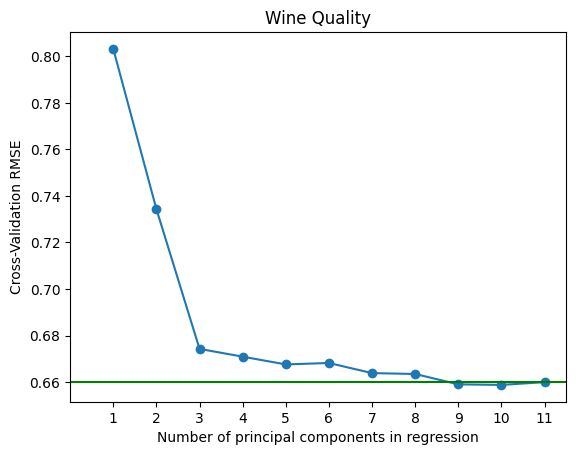

In [ ]:
# Plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Cross-Validation RMSE')
plt.title('Wine Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

In [ ]:
best_pc_num = ?

In [ ]:
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

lr_scores_pva = -1 * cross_val_score(lin_reg_pc, 
                                    X_train_pc[:,:best_pc_num], 
                                    y_train, 
                                    cv=cv, 
                                    scoring='neg_root_mean_squared_error')
print('PCA')
print(f'-RMSE training score: {np.mean(lr_scores_pva)}')
print(f'R^2 score: {lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train):.5f}')

#### PCR through pipline

In [ ]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pcr.predict(X_test)